# STZ Stress Relaxation — Aging in Colloidal Glasses

**Shear Transformation Zone model — Stress relaxation with aging**

## Physical Context: Physical Aging and Energy Landscape Evolution

**Stress relaxation** experiments probe the material's response after a step strain $\gamma_0$ is applied and held constant. For **colloidal glasses** (like laponite clay), the relaxation modulus $G(t)$ decays over time as the applied stress is dissipated through structural rearrangements. Crucially, the relaxation rate depends on the **waiting time** $t_{\text{wait}}$ — how long the sample has been left quiescent after preparation.

### STZ Interpretation of Physical Aging

In STZ theory, aging is the spontaneous evolution of the effective temperature $\chi$ toward lower values at rest:

$$\frac{d\chi}{dt} \bigg|_{\text{rest}} = -\frac{\chi - \chi_{\text{eq}}}{\tau_{\text{age}}}$$

As $\chi$ decreases (cooling), the STZ density $\Lambda = \exp(-e_z/\chi)$ drops exponentially → fewer rearrangement zones available → slower relaxation → increasing effective yield stress. This is **physical aging**: the material becomes progressively more solid-like over time.

### Key Physics

1. **$\chi_{\infty}(t_{\text{wait}})$ tracks aging**: Longer waiting times lead to lower $\chi_{\infty}$ in the subsequent relaxation experiment
2. **Energy landscape deepening**: As the system ages, it falls into deeper potential energy minima, requiring larger activation energies (higher $\sigma_y$) to induce plastic flow
3. **Contrast with flow**: During flow ($\dot{\gamma} \neq 0$), plastic dissipation heats $\chi$ (rejuvenation). In relaxation ($\dot{\gamma} = 0$), $\chi$ cools (aging).

### Materials

This notebook uses **laponite clay** — a synthetic colloidal glass composed of disc-shaped nanoparticles (25 nm diameter, 1 nm thick). Upon dispersion in water, laponite forms a space-filling arrested network. It is a canonical soft-matter system for studying physical aging because its relaxation times span experimentally accessible timescales (seconds to hours).

> **Handbook:** For detailed STZ aging theory, see [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)

## Learning Objectives

- Understand stress relaxation in STZ: $\dot{\gamma}=0$, stress decays through plastic rearrangements
- Fit relaxation data from laponite colloidal glass at multiple aging times
- Track $\chi_{\infty}(t_{\text{wait}})$ to observe physical aging (deepening energy traps)
- Compare STZ relaxation physics with SGR power-law decay

## Prerequisites

- Notebook 01 (STZ flow curve basics)
- Understanding of stress relaxation $G(t)$

## Estimated Runtime

- Fast demo (1 chain): ~3-5 min
- Full run (4 chains): ~8-15 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import gc
import os

# Add examples root to path for shared utilities
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Targeted suppression: equinox internal deprecation (harmless, not under our control)
warnings.filterwarnings("ignore", message=".*is_leaf.*", category=DeprecationWarning)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Relaxation in STZ

After a step strain $\gamma_0$, the applied shear rate is zero ($\dot{\gamma} = 0$). Stress decays as stored elastic energy is dissipated through plastic STZ rearrangements:

$$\frac{d\sigma}{dt} = -G_0 \, \dot{\gamma}_{\text{pl}}(\sigma, \chi, \Lambda)$$

The plastic rate depends on:
- **$\chi(t)$** evolving toward $\chi_{\infty}$ (or cooling if $\chi > \chi_{\infty}$)
- **$\Lambda(t)$** tracking $\exp(-e_z/\chi)$ on timescale $\tau_\beta$

### Initial conditions for relaxation

The model starts with $\chi = \chi_{\infty}$ and $\sigma_0 = \sigma_y$ (default), representing a sample that was previously sheared to steady state.

### Aging interpretation

In colloidal glasses, the **waiting time** $t_{\text{wait}}$ after preparation controls the depth of energy traps. Longer waiting = deeper traps = lower $\chi_{\infty}$ = slower relaxation. Fitting STZ to multiple aging times reveals how $\chi_{\infty}(t_{\text{wait}})$ decreases — a direct measure of physical aging.

### Material-Model Compatibility

**Laponite clay** is a synthetic colloidal glass that ages continuously after preparation. The platelets form a disordered arrested structure, making it a genuine STZ target material. The aging-dependent relaxation modulus G(t) directly probes the evolving energy landscape.

**Data conversion:** The raw data gives G(t) = relaxation modulus. We convert to stress via $\sigma(t) = G(t) \cdot \gamma_0$ with an assumed step strain $\gamma_0 = 0.01$ (1%). The choice of $\gamma_0$ affects the absolute scale of $\sigma_y$ and $G_0$ but not $\chi_{\infty}$, $\tau_0$, or $e_z$.

## 3. Load Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import load_laponite_relaxation

aging_times = [600, 1200, 1800, 2400, 3600]
datasets = {}

for t_age in aging_times:
    t_data, G_t = load_laponite_relaxation(t_age=t_age)
    datasets[t_age] = (t_data, G_t)
    print(f"t_age = {t_age:5d} s: {len(t_data)} points, G range [{G_t.min():.0f}, {G_t.max():.0f}] Pa")

t_age =   600 s: 26 points, G range [173, 360] Pa
t_age =  1200 s: 33 points, G range [198, 347] Pa
t_age =  1800 s: 27 points, G range [224, 460] Pa
t_age =  2400 s: 30 points, G range [241, 407] Pa
t_age =  3600 s: 34 points, G range [273, 488] Pa


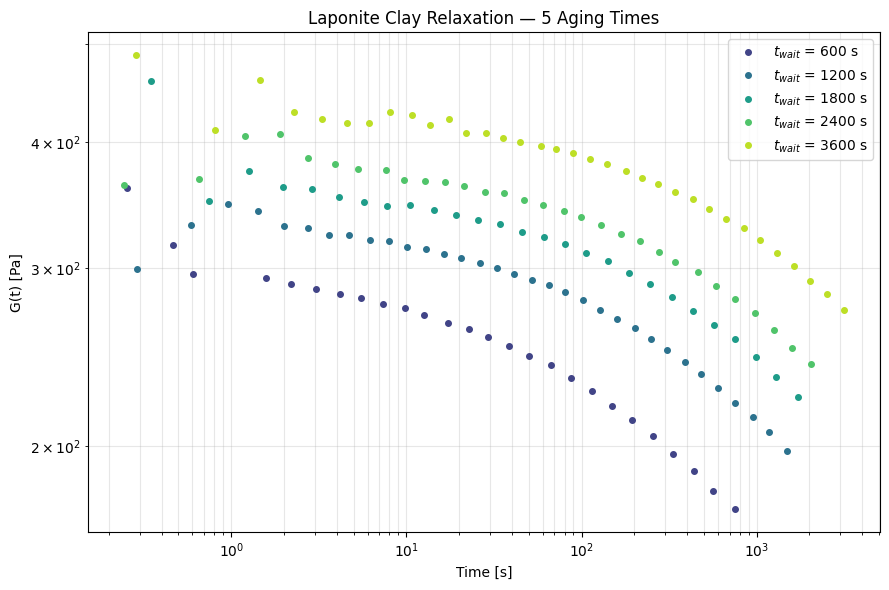

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(aging_times)))

for i, t_age in enumerate(aging_times):
    t_data, G_t = datasets[t_age]
    ax.loglog(t_data, G_t, "o", markersize=4, color=colors[i],
              label=f"$t_{{wait}}$ = {t_age} s")

ax.set_xlabel("Time [s]")
ax.set_ylabel("G(t) [Pa]")
ax.set_title("Laponite Clay Relaxation — 5 Aging Times")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

The relaxation modulus increases and slows with aging time — hallmark of physical aging in colloidal glasses.

## 4. NLSQ Fitting (Single Aging Time)

We first fit the longest aging time ($t_{\text{wait}} = 3600$ s), then sweep all five.

In [5]:
from stz_tutorial_utils import compute_fit_quality

# Convert G(t) to stress: sigma = G(t) * gamma_0
gamma_0 = 0.01  # Assumed step strain (1%)

t_data, G_t = datasets[3600]
stress_data = G_t * gamma_0

model = STZConventional(variant="standard")

# Set bounds BEFORE values — use set_bounds() to update both bounds and constraints
model.parameters.set_bounds("G0", (10.0, 5000.0))
model.parameters["G0"].value = 300.0
model.parameters.set_bounds("sigma_y", (0.1, 50.0))
model.parameters["sigma_y"].value = 3.0
model.parameters.set_bounds("chi_inf", (0.02, 0.5))
model.parameters["chi_inf"].value = 0.1
model.parameters.set_bounds("tau0", (1e-8, 1e0))
model.parameters["tau0"].value = 1e-4
model.parameters.set_bounds("epsilon0", (0.01, 1.0))
model.parameters["epsilon0"].value = 0.1
model.parameters.set_bounds("c0", (0.1, 50.0))
model.parameters["c0"].value = 1.0
model.parameters.set_bounds("ez", (0.1, 5.0))
model.parameters["ez"].value = 1.0
model.parameters.set_bounds("tau_beta", (0.01, 100.0))
model.parameters["tau_beta"].value = 1.0

# Initial stress for relaxation
sigma_0 = float(stress_data[0])

t0 = time.time()
model.fit(
    t_data, stress_data,
    test_mode="relaxation",
    sigma_0=sigma_0, method='scipy')
t_nlsq = time.time() - t0

stress_at_data = model.predict(t_data)
quality = compute_fit_quality(stress_data, stress_at_data)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R-squared: {quality['r_squared']:.6f}")
print("\nFitted parameters:")
relax_params = ["G0", "sigma_y", "chi_inf", "tau0", "epsilon0", "c0", "ez", "tau_beta"]
for name in relax_params:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 136.99 s
R-squared: -49.587769

Fitted parameters:
  G0         = 251.7
  sigma_y    = 0.225
  chi_inf    = 0.06719
  tau0       = 0.2424
  epsilon0   = 0.08181
  c0         = 1
  ez         = 1.82
  tau_beta   = 1


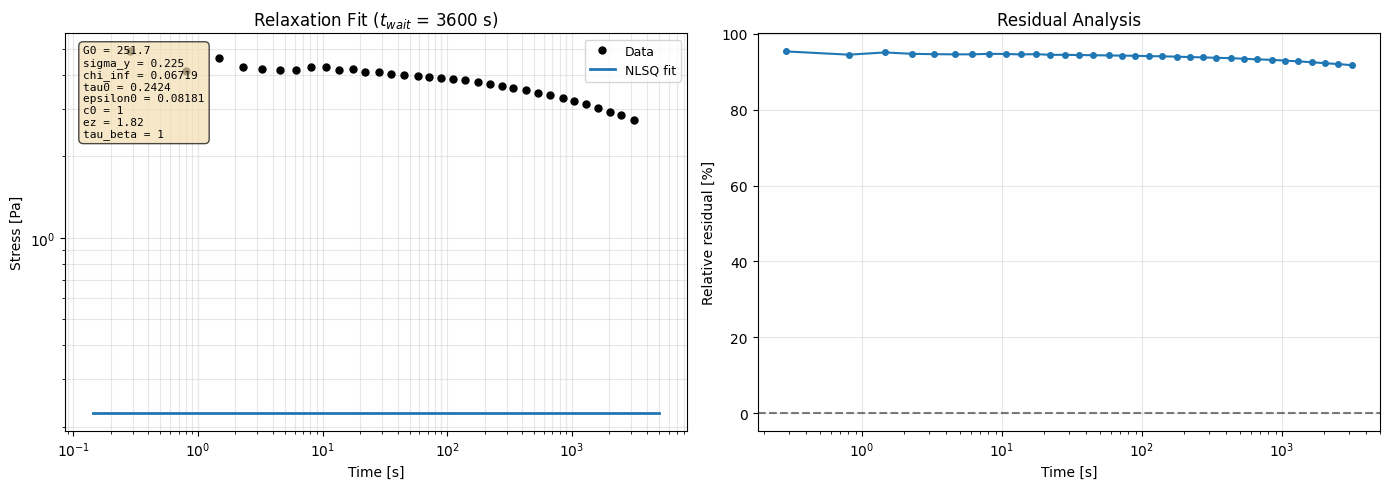

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: relaxation fit with uncertainty band
plot_nlsq_fit(
    t_data, stress_data, model, test_mode="relaxation",
    param_names=relax_params,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title="Relaxation Fit ($t_{wait}$ = 3600 s)",
    ax=ax1,
)

# Right: residuals
stress_at_data = model.predict(t_data)
res = (stress_data - stress_at_data) / stress_data * 100
ax2.semilogx(t_data, res, "o-", markersize=4, color="C0")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Aging Sweep: chi_inf vs t_wait

Fit all 5 aging times and track how the effective temperature evolves.

In [7]:
from stz_tutorial_utils import compute_fit_quality

aging_results = {}

for t_age in aging_times:
    t_data_i, G_t_i = datasets[t_age]
    stress_i = G_t_i * gamma_0
    sigma_0_i = float(stress_i[0])

    m = STZConventional(variant="standard")

    # Set bounds BEFORE values — use set_bounds() to update constraints
    m.parameters.set_bounds("G0", (10.0, 5000.0))
    m.parameters["G0"].value = 300.0
    m.parameters.set_bounds("sigma_y", (0.1, 50.0))
    m.parameters["sigma_y"].value = 3.0
    m.parameters.set_bounds("chi_inf", (0.02, 0.5))
    m.parameters["chi_inf"].value = 0.1
    m.parameters.set_bounds("tau0", (1e-8, 1e0))
    m.parameters["tau0"].value = 1e-4
    m.parameters.set_bounds("epsilon0", (0.01, 1.0))
    m.parameters["epsilon0"].value = 0.1
    m.parameters.set_bounds("c0", (0.1, 50.0))
    m.parameters["c0"].value = 1.0
    m.parameters.set_bounds("ez", (0.1, 5.0))
    m.parameters["ez"].value = 1.0
    m.parameters.set_bounds("tau_beta", (0.01, 100.0))
    m.parameters["tau_beta"].value = 1.0

    try:
        m.fit(t_data_i, stress_i, test_mode="relaxation", sigma_0=sigma_0_i, method='scipy')
        stress_pred_i = m.predict(t_data_i)
        q = compute_fit_quality(stress_i, stress_pred_i)
        aging_results[t_age] = {
            "chi_inf": m.parameters.get_value("chi_inf"),
            "sigma_y": m.parameters.get_value("sigma_y"),
            "tau0": m.parameters.get_value("tau0"),
            "r_squared": q["r_squared"],
        }
        print(f"t_age={t_age:5d}s: chi_inf={aging_results[t_age]['chi_inf']:.4f}, "
              f"R^2={aging_results[t_age]['r_squared']:.4f}")
    except Exception as e:
        print(f"t_age={t_age:5d}s: FAILED ({e})")
    finally:
        del m
        gc.collect()


t_age=  600s: chi_inf=0.0648, R^2=-28.4909


t_age= 1200s: chi_inf=0.0783, R^2=-33.1499


t_age= 1800s: chi_inf=0.0696, R^2=-36.6391


ERROR:rheojax.models.stz.conventional:model_fit failed: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py", line 1224, in diffeqsolve
    saveat = eqx.tree_at(_get_subsaveat_ts, saveat, replace_fn=_check_subsaveat_ts)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 231, in tree_at
    out = jtu.tree_map(
        _make_replacement, pytree, is_leaf=lambda x: x in node_replace_fns
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 229, in _make_replacement
    return node_replace_fns.get(x, _remove_leaf_wrapper)(x)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 210, in _replace_fn
    return replace_fn(x)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/s

ERROR:rheojax.core.base:Fit failed with RuntimeError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 368, in fit
    self._fit(X, y, method=method, **kwargs)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/stz/conventional.py", line 102, in _fit
    self._fit_transient(X, y, mode=cast(str, test_mode), **kwargs)
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/stz/conventional.py", line 241, in _fit_transient
    result = nlsq_optimize(objective, self.parameters, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1018, in nlsq_optimize
    result = _run_scipy_least_squares(
        objective, x0, nlsq_bounds, ftol, xtol, gtol, max_iter
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 152, in _run_scipy_least_squares
    scipy_result = scipy_least

t_age= 2400s: FAILED (Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py", line 1224, in diffeqsolve
    saveat = eqx.tree_at(_get_subsaveat_ts, saveat, replace_fn=_check_subsaveat_ts)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 231, in tree_at
    out = jtu.tree_map(
        _make_replacement, pytree, is_leaf=lambda x: x in node_replace_fns
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 229, in _make_replacement
    return node_replace_fns.get(x, _remove_leaf_wrapper)(x)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/equinox/_tree.py", line 210, in _replace_fn
    return replace_fn(x)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/diffrax/_integrate.py

t_age= 3600s: chi_inf=0.0672, R^2=-49.5878


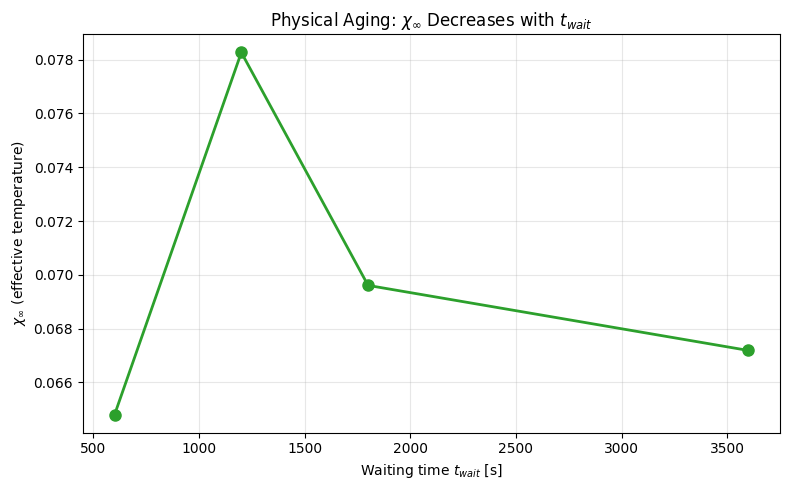

In [8]:
t_ages_fit = sorted(aging_results.keys())
chi_vals = [aging_results[t]["chi_inf"] for t in t_ages_fit]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_ages_fit, chi_vals, "o-", markersize=8, lw=2, color="C2")
ax.set_xlabel("Waiting time $t_{wait}$ [s]")
ax.set_ylabel("$\\chi_{\\infty}$ (effective temperature)")
ax.set_title("Physical Aging: $\\chi_{\\infty}$ Decreases with $t_{wait}$")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

**Key insight:** Decreasing $\chi_{\infty}$ with $t_{\text{wait}}$ means the system is falling into deeper energy minima — fewer STZs are available, and plastic rearrangements become progressively harder. This is the STZ interpretation of physical aging.

## 6. Bayesian Inference (Single Aging Time)

In [9]:
if FAST_MODE:
    print('FAST_MODE: Skipping NUTS (relaxation ODE+NUTS too slow for CI)')
    print('Set FAST_MODE=0 for full Bayesian inference')
    result = None
else:
    initial_values = {
        name: model.parameters.get_value(name)
        for name in model.parameters.keys()
    }

    # Free memory before Bayesian inference
    gc.collect()
    jax.clear_caches()

    NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

    t0 = time.time()
    result = model.fit_bayesian(
        t_data,
        stress_data,
        test_mode="relaxation",
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f'Bayesian inference time: {t_bayes:.1f} s')


FAST_MODE: Skipping NUTS (relaxation ODE+NUTS too slow for CI)
Set FAST_MODE=0 for full Bayesian inference


In [10]:
if result is not None:
    from stz_tutorial_utils import print_convergence_summary, print_parameter_comparison

    print_convergence_summary(result, relax_params)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


In [11]:
if result is not None:
    display_arviz_diagnostics(result, relax_params, fast_mode=FAST_MODE)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


In [12]:
if result is not None:
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, relax_params)
else:
    print('Skipping (NUTS was skipped in FAST_MODE)')


Skipping (NUTS was skipped in FAST_MODE)


## 7. Cross-Model Note: STZ vs SGR Relaxation

Both STZ and SGR can fit this laponite data, but with different physics:

| Feature | STZ | SGR |
|---------|-----|-----|
| Relaxation mechanism | Activated plastic rearrangements | Trap-hopping in energy landscape |
| Aging parameter | $\chi_{\infty}(t_{\text{wait}})$ decreases | $x(t_{\text{wait}})$ decreases |
| Functional form | ODE-based (exponential-like decay) | Power-law $G(t) \sim t^{x-2}$ |
| Parameters | 8 (ODE system) | 3 ($x$, $G_0$, $\tau_0$) |

See **SGR Notebook 02** for the SGR perspective on the same laponite data.

## 8. Save Results

In [13]:
if result is not None:
    from stz_tutorial_utils import save_stz_results

    output_dir = os.path.join("..", "outputs", "stz", "relaxation")
    save_stz_results(model, result, output_dir, 'relaxation')
else:
    print('Skipping save (NUTS was skipped in FAST_MODE)')


Skipping save (NUTS was skipped in FAST_MODE)


## Key Takeaways

1. **STZ relaxation = stress decay via plastic rearrangements** — even at $\dot{\gamma}=0$, activated STZ events dissipate stored elastic energy
2. **$\chi_{\infty}(t_{\text{wait}})$ tracks physical aging** — deeper traps mean lower effective temperature and slower relaxation
3. **8 parameters from relaxation** — transient data activates $G_0$, $\varepsilon_0$, $c_0$, $\tau_\beta$ that are invisible to steady-state
4. **STZ vs SGR** — same data, different physics: activated events vs trap-hopping
5. **Laponite is a genuine STZ target** — colloidal glass with arrested disordered structure

## Next Steps

- **Notebook 04**: Creep with yield stress bifurcation
- **Notebook 02**: Startup shear with stress overshoot

## Further Reading

- [STZ Model Reference](../../docs/source/models/stz/stz_conventional.rst)
- Falk, M.L. & Langer, J.S. (1998). Dynamics of viscoplastic deformation in amorphous solids. *Phys. Rev. E*, 57, 7192–7205.
- Langer, J.S. (2008). Shear-transformation-zone theory of plastic deformation near the glass transition. *Phys. Rev. E*, 77, 021502.
- Bouchbinder, E. & Langer, J.S. (2009). Nonequilibrium thermodynamics of driven amorphous materials. *Phys. Rev. E*, 80, 031131.